## Basics

In [1]:
def get_results_for_p(p,all_results):
    # Create the key as a tuple
    #key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.k_entry,p.k_f,p.prod_alpha,p.dt)
    key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.prod_alpha,p.dt,p.u_bf_m)
    # Check if the key exists in the saved results
    if key in all_results:
        print(key)
        return all_results[key]
    else:
        print(f"No results found for p = {key}")
        return None

from primitives import Parameters
p = Parameters()
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
import cProfile
import pstats

plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_sd_J,mwc_sd_W,mwc_sd_Wstar,mwc_sd_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
# Load the temp objects
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

# Load the permanent results, for sep, across different parametrizations
with open("results_Rho_sep.pkl", "rb") as file:
    all_results = pickle.load(file)
results = get_results_for_p(p,all_results)

(3, 100, 5, 4, 6, 0.5, 0.5, 3.0, 0.5, 0.25, 0.05)


In [3]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(1)

In [4]:
from Multiworker_Contract_hire_Rho import MultiworkerContract
mwc_Rho=MultiworkerContract(p,cc.js)

In [5]:
#mwc_Rho_J = objects['mwc_Rho_J']
#mwc_Rho_W = objects['mwc_Rho_W']

profiler = cProfile.Profile()
profiler.enable()
(mwc_Rho_J,mwc_Rho_W,mwc_Rho_Rho,mwc_Rho_Wstar,mwc_Rho_pc,mwc_Rho_n0,mwc_Rho_n1)=mwc_Rho.J()
profiler.disable()
# Print profiling results
stats = pstats.Stats(profiler).sort_stats(pstats.SortKey.TIME)
stats.print_stats()

objects['mwc_Rho_J'] = mwc_Rho_J
objects['mwc_Rho_W'] = mwc_Rho_W
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

Jshape (3, 5, 5, 100, 6)
W shape (3, 5, 5, 100, 6, 2)
n0_star borders 0.0 3.234050763593218
Diff Rho: 0.1570103749163362
Errors: 1.686187856044104e+43 0.11792815604718859 1
n0_star borders 0.0 3.2512998464380907
Diff Rho: 4.528090601177813
EJinv -182.6574497219833
EJderiv -101.11744263573294
EJinv diff 1j 2s: 1.7666888754865424
EJinv diff 1 sen: 9.020683018494754
EJinv diff 2 sen: 0.7843548949840653
n0_star borders 0.0 2.2387328144408656
Diff Rho: 10.735691715283844
EJinv -119.14713737978232
EJderiv -115.8936364991381
EJinv diff 1j 2s: 0.22424116038941425
EJinv diff 1 sen: 3.376790112133213
EJinv diff 2 sen: 0.8130091414288187
n0_star borders 0.0 1.726670227966247
Diff Rho: 13.358046750367912
EJinv -97.48508880522523
EJderiv -127.13271934773616
EJinv diff 1j 2s: 7.810147552890894
EJinv diff 1 sen: 1.3614993870000085
EJinv diff 2 sen: 0.2409928924662418
n0_star borders 0.0 1.496455897352219
Diff Rho: 8.43011124692143
EJinv -97.00202418388763
EJderiv -44.14222212675625
EJinv diff 1j 2s: 

In [5]:
if results is None:
    mwc_Rho_s_J = objects['mwc_Rho_s_J']
    mwc_Rho_s_W = objects['mwc_Rho_s_W']
else:
    mwc_Rho_s_J = results['J']
    mwc_Rho_s_W = results['W']

(mwc_Rho_s_J,mwc_Rho_s_W,mwc_Rho_s_Rho,mwc_Rho_s_Wstar,mwc_Rho_s_sep,mwc_Rho_s_n0,mwc_Rho_s_n1)=mwc_Rho.J_sep_dir()

objects['mwc_Rho_s_J'] = mwc_Rho_s_J
objects['mwc_Rho_s_W'] = mwc_Rho_s_W
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

Jshape (3, 5, 5, 100, 6)
W shape (3, 5, 5, 100, 6, 2)
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
n0_star borders 0.0 3.234050763593218
Diff Rho: 1.3656264909103566e-05
Errors: 9.964571972794095e+42 0.11732860535786704 1
sep borders 0.0 1.0
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 3.251343349271802
Diff Rho: 14.742338378700913
EJinv -183.17573796533136
EJderiv -72.40898125348616
EJinv diff 1j 2s: 3.0832529425866597
EJinv diff 1 sen: 10.155378416296099
EJinv diff 2 sen: 1.3056430774480676
sep borders 0.0 1.0
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 3.051650965284387
Diff Rho: 15.705220063137865
EJinv -121.51323666186809
EJderiv -187.95077152800525
EJinv diff 1j 2s: 0.2899698623395734
EJinv diff 1 sen: 19.669935199733345
EJinv diff 2 sen: 0.9038466345645323
sep borders 0.0 1.0
q_star [1. 1. 1. 1. 1. 1.]
n0_star borders 0.0 2.2700306685060725
Diff Rho: 10.979681721340373
EJinv -132.61085788513452
EJderiv -211.11638967195654
EJinv diff 1j 2s: 0.3113467046528593
EJinv diff 1 sen: 51.102362

SystemError: CPUDispatcher(<function n0 at 0x000001EC5EECA5C0>) returned a result with an exception set

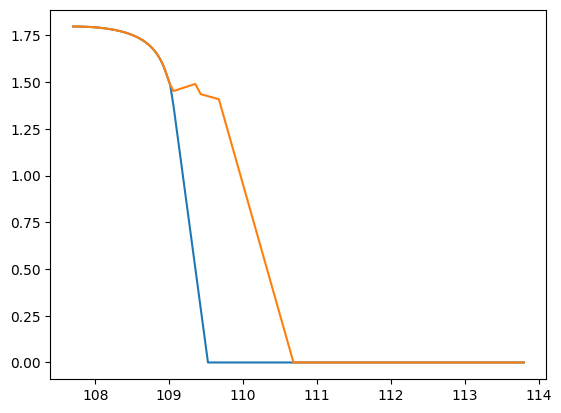

In [7]:
prod = p.z_0-0
j=0
s=1
#plt.plot(mwc_W[p.z_0-1,0,1,:,1],mwc_J[p.z_0-1,0,1,:])
#plt.plot(mwc.w_grid,mwc_n0[p.z_0,0,0,:])
#plt.plot(mwc.w_grid,mwc_W[p.z_0,0,1,:,1])
#plt.plot(mwc_W[p.z_0,0,1,:,1],mwc_n0[p.z_0,0,1,:])
#plt.plot(mwc_W[p.z_0-1,1,1,:,1],mwc_n0[p.z_0-1,1,1,:])
#plt.plot(mwc_Rho_W[p.z_0,0,0,:,5,1],mwc_Rho_n0[p.z_0,0,0,:,5])
plt.plot(mwc_Rho_W[prod,j,s,:,0,1],mwc_Rho_n0[prod,j,s,:,0])
plt.plot(mwc_Rho_s_W[prod,j,s,:,0,1],mwc_Rho_s_n0[prod,j,s,:,0])


#Something is very wrong here, for some reason, when the seniors are the "cheapest" (lowest w_grid), the firm doesn't hire???
#Also the top part is still...kinda weird
#Also no hiring at 1 junior, but hiring at 1 senior???

FOR TOMORROW: Things look not too bad overall, the main issue is that separations are damn weird. The firm only ever fires at [3,3]. Should I try other unemp values?

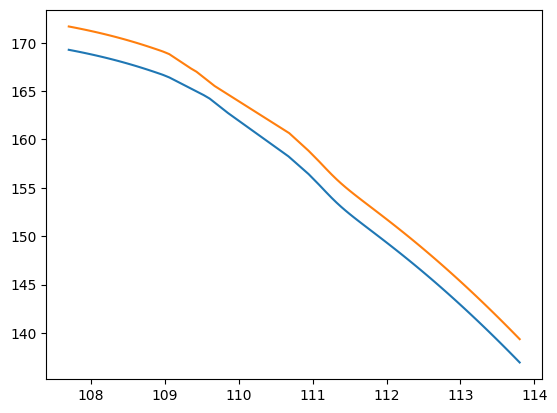

In [8]:
prod = p.z_0-0
j=0
s=1
#plt.plot(mwc_W[p.z_0,j,s,:,1],mwc_J[p.z_0,j,s,:])
#plt.plot(mwc_hmq_W[p.z_0,j,s,:,0,1],mwc_hmq_J[p.z_0,j,s,:,0]-mwc_hmq_J[p.z_0,j-1,s,:,0])
#plt.plot(mwc_Rho_W[p.z_0,j,s,:,0,1],mwc_Rho_J[p.z_0,j,s,:,0]-mwc_Rho_J[p.z_0,j-1,s,:,0])
plt.plot(mwc_Rho_W[prod,j,s,:,0,1],mwc_Rho_J[prod,j,s,:,0])
plt.plot(mwc_Rho_s_W[prod,j,s,:,0,1],mwc_Rho_s_J[prod,j,s,:,0])

#plt.plot(mwc_Rho.w_grid,mwc_Rho_J[prod,j,s,:,0])
#plt.plot(mwc_hmq_W[prod,j,s,:,0,1],mwc_hmq_J[prod,j,s,:,0])
#plt.plot(mwc_Rho_W[p.z_0,j,s,:,0,1],mwc_Rho_n1[p.z_0,j,s,:,0])

In [ ]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()

So, big question for tomorrow: what the fuck is going on? Why doesn't the firm hire at the lowest worker value???

Same issue here, the value of hiring is initially increasing... for no reason whatsoever

In [7]:
from Multiworker_Contract_GE import MultiworkerContract
mwc_GE=MultiworkerContract(p)

In [ ]:
# GE basic
#mwc_GE_J = objects['mwc_GE_J']
#mwc_GE_W = objects['mwc_GE_W']
mwc_GE_J = objects['mwc_hmq_J']
mwc_GE_W = objects['mwc_hmq_W']


(mwc_GE_J,mwc_GE_W,mwc_GE_Wstar,mwc_GE_sep,mwc_GE_n0,mwc_GE_n1)=mwc_GE.J(mwc_GE_J,mwc_GE_W,0)

objects['mwc_GE_J'] = mwc_GE_J
objects['mwc_GE_W'] = mwc_GE_W
 
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
# GE separations
if results is None:
    mwc_GE_s_J = objects['mwc_GE_J']
    mwc_GE_s_W = objects['mwc_GE_W']
else:
    mwc_GE_s_J = results['Ji']
    mwc_GE_s_W = results['W1i']

(mwc_GE_s_J,mwc_GE_s_W,mwc_GE_s_Wstar,mwc_GE_s_sep,mwc_GE_s_n0,mwc_GE_s_n1)=mwc_GE.J_sep_dir(mwc_GE_J,mwc_GE_W,1)

objects['mwc_GE_s_J'] = mwc_GE_s_J
objects['mwc_GE_s_W'] = mwc_GE_s_W
 
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

# Plots

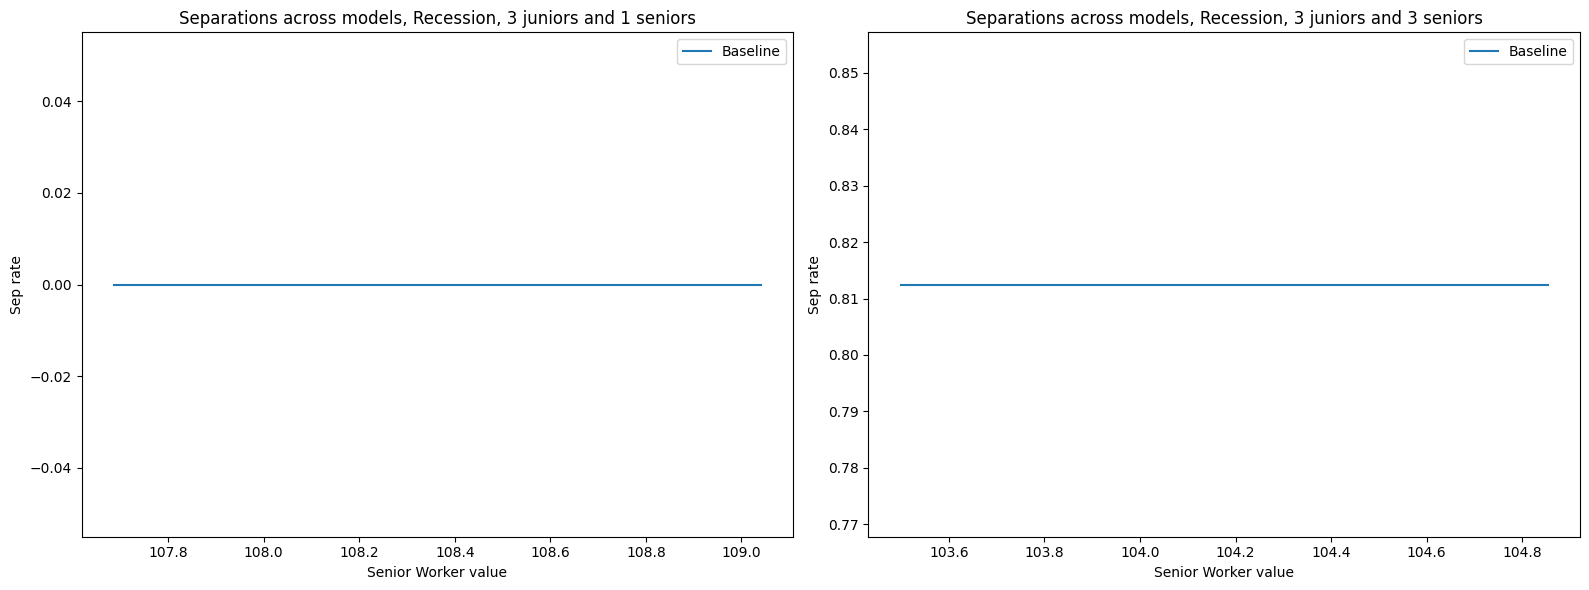

In [11]:
plot_sep(0,0,    3,1,    3,3,    0,  0,0,    0)

In [10]:
def plot_sep(prod1,prod2,jun1,sen1,jun2,sen2,qual,minwage=0,hiresub=0, save=0):       
 
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        prod=prod1
        jun=jun1
        sen=sen1

        #plt.plot(mwc_GE_s_W[prod1, jun, sen, :, qual ,1], mwc_GE_s_sep[prod1, jun, sen, :, qual], label='Baseline')
        plt.plot(mwc_Rho_s_W[prod1, jun, sen, :, qual ,1], mwc_Rho_s_sep[prod1, jun, sen, :, qual], label='Baseline')

     

        if prod1 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod1 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()
        # Second subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        prod=prod2
        jun=jun2
        sen=sen2

        #plt.plot(mwc_GE_s_W[prod2, jun, sen, :, qual ,1], mwc_GE_s_sep[prod2, jun, sen, :, qual], label='Baseline')
        plt.plot(mwc_Rho_s_W[prod2, jun, sen, :, qual ,1], mwc_Rho_s_sep[prod2, jun, sen, :, qual], label='Baseline')
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod2 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'Separations main 2.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [7]:
names = [ 'DRS HMQ', 'DRS HMQ via RHO', 'HMQ']

In [ ]:
plts.CRSvsDRSvalue(names,cc_W,cc_J,mwc_hmq_W[...,0,:],mwc_Rho_J[...,0],mwc_Rho_W[...,0,:],mwc_Rho_J[...,0],None,None,0)

In [9]:
def plot_GE(prod1,prod2,jun1,sen1,jun2,sen2,qual,minwage=0,hiresub=0, save=0):       
 
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        prod=prod1
        jun=jun1
        sen=sen1
       
        plt.plot(mwc_GE_W[prod1, jun, sen, :, qual ,1], mwc_GE_J[prod1, jun, sen, :, qual], label='Baseline')
        if mwc_GE_s_W is not None:
          plt.plot(mwc_GE_s_W[prod1, jun, sen, :, qual ,1], mwc_GE_s_J[prod1, jun, sen, :, qual], label='With separations')


     

        if prod1 == 2:
          plt.title(f'Firm Value, Boom, {jun} juniors and {sen} seniors')
        elif prod1 == 0:
          plt.title(f'Firm Value, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Firm Value, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Firm Value')
        plt.legend()
        # Second subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        prod=prod2
        jun=jun2
        sen=sen2
        plt.plot(mwc_GE_W[prod2, jun, sen, :, qual ,1], mwc_GE_J[prod2, jun, sen, :, qual], label='Baseline')
        if mwc_GE_s_W is not None:
          plt.plot(mwc_GE_s_W[prod2, jun, sen, :, qual ,1], mwc_GE_s_J[prod2, jun, sen, :, qual], label='With separations')

       
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Firm Value, Boom, {jun} juniors and {sen} seniors')
        elif prod2 == 0:
          plt.title(f'Firm Value, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Firm Value, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Firm Value')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'General Equilibrium Value Function.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [ ]:
plot_GE(2,0,    1,2,    1,1,    0,  0,0,    0)

In [6]:
baseline_sep = objects['baseline_sep']
baseline_W = objects['baseline_W']
baseline_Wstar = objects['baseline_Wstar']


noHMQ_sep = objects['noHMQ_sep']
noHMQ_W = objects['noHMQ_W']
noHMQ_Wstar = objects['noHMQ_Wstar']
nohire_sep = objects['nohire_sep']
nohire_W = objects['nohire_W']
nohire_Wstar = objects['nohire_W']
hiresub_sep = objects['hiresub_sep']
hiresub_W = objects['hiresub_W']
hiresub_Wstar = objects['hiresub_Wstar']

In [7]:
import os
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [8]:
def plott(prod1,prod2,jun1,sen1,jun2,sen2,qual,minwage=0,hiresub=0, save=0):       
 
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        prod=prod1
        jun=jun1
        sen=sen1
        if baseline_W is not None:        
            plt.plot(baseline_W[prod1, jun, sen, 5:50, qual ,1], baseline_sep[prod1, jun, sen, 5:50, qual], label='Baseline')
        plt.plot(mwc_hmq_sd_W[prod1, jun, sen, 5:50, qual ,1], mwc_hmq_sd_sep[prod1, jun, sen, 5:50, qual], label='New baseline')
        if nohire_W is not None:        
         plt.plot(nohire_W[prod1, jun, sen, 5:50, qual ,1], nohire_sep[prod1, jun, sen, 5:50, qual], label='CRS') #Not true CRS but still
        #if noHMQ_W is not None:        
        # plt.plot(noHMQ_W[prod1, jun, sen, 5:50, qual, 1], noHMQ_sep[prod1, jun, sen, 5:50, qual], label='No match heterog')
        #if minwage_W is not None: 
        # if minwage ==1: 
        #  plt.plot(minwage_W[prod1, jun, sen, 5:50, qual, 1], minwage_sep[prod1, jun, sen, 5:50, qual], label='Min wage')
        if hiresub ==1 :
          plt.plot(hiresub_W[prod1, jun, sen, 5:50, qual, 1], hiresub_sep[prod1, jun, sen, 5:50, qual], label='Hiring subsidy')

     

        if prod1 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod1 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()
        # Second subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        prod=prod2
        jun=jun2
        sen=sen2
        if baseline_W is not None:        
            plt.plot(baseline_W[prod2, jun, sen, 5:50, qual, 1], baseline_sep[prod2, jun, sen, 5:50, qual], label='Baseline')
        plt.plot(mwc_hmq_sd_W[prod2, jun, sen, 5:50, qual ,1], mwc_hmq_sd_sep[prod2, jun, sen, 5:50, qual], label='New baseline')
        if nohire_W is not None:        
         plt.plot(nohire_W[prod2, jun, sen, 5:50, qual, 1], nohire_sep[prod2, jun, sen, 5:50, qual], label='CRS')  
        #if noHMQ_W is not None:        
        # plt.plot(noHMQ_W[prod2, jun, sen, 5:50, qual, 1], noHMQ_sep[prod2, jun, sen, 5:50, qual], label='No match heterog')     
        #if minwage_W is not None:
        # if minwage == 1:  
        #  plt.plot(minwage_W[prod2, jun, sen, 5:50, qual, 1], minwage_sep[prod2, jun, sen, 5:50, qual], label='Min wage')
        if hiresub ==1 :
          plt.plot(hiresub_W[prod2, jun, sen, 5:50, qual, 1], hiresub_sep[prod2, jun, sen, 5:50, qual], label='Hiring subsidy')            
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod2 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'Separations main 2.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [ ]:
plott(0,0,  1,3,    2,2,    5,0,0,save=0)

In [ ]:
plott(0,0,  1,1,    1,3,    5, 0,0, save=0)

In [ ]:
        prod2=0
        save=1
        qual = 5
        if baseline_W is not None:        
            plt.plot(baseline_W[prod2, 1, 1, 5:, qual, 1], baseline_sep[prod2, 1, 1, 5:, qual], label='Small firm')
        if baseline_W is not None:        
            plt.plot(baseline_W[prod2, 1, 3, 5:, qual, 1], baseline_sep[prod2, 1, 3, 5:, qual], label='Larger firm')  
        #if baseline_W is not None:        
        
        #plt.plot(baseline_W[prod2, 1, 3, 5:, qual, 1], baseline_sep[prod2, 1, 3, 5:, qual], label='Many seniors')     
         
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Separations across size, Boom')
        elif prod2 == 0:
          plt.title(f'Separations across size, Recession')
        else:
          plt.title(f'Separations across size, {prod} productivity')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'Separations across size new.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [ ]:
        #THIS IS SOMEHOW THE OPPOSITE??? In firms with many juniors wage drops are larger?? Why?? I guess they don't care for that many seniors?
        #But then why would it equialize afterwards... AHHH BECAUSE ALL THE JUNIORS ARE ALREADY FIRED
        #Now 1,3 places much higher weight on its expensive seniors hencewhy wage drop not that large...? WAGE DROP BOUNCES UP A BIT WHEN THEY START FIRING
        #Still can't understand why 1,1 goes for full firing earlier tho... Also at the same time that complete firing happens, wage drops amplify... guess that makes sense tho
        save=0
        plt.figure(figsize=(8, 6))  # Width=16 inches, Height=12 inches

        # Plot the data
        plt.plot(baseline_W[0, 1, 1 ,:, 5, 1], baseline_Wstar[0, 1, 1 ,:, 5]-baseline_W[0, 1, 1 ,:, 5, 1], label='Small firm')
        plt.plot(baseline_W[0, 1, 3 ,:, 5, 1], baseline_Wstar[0, 1, 3 ,:, 5]-baseline_W[0, 1, 3 ,:, 5, 1], label='Larger firm')
        #plt.plot(baseline_W[0, 3, 1 ,:, 5, 1], baseline_Wstar[0, 3, 1 ,:, 5]-baseline_W[0, 3, 1 ,:, 5, 1], label='Larger firm wage')
        #if mwc_s_W is not None:
        #    plt.plot(mwc_s_W[p.z_0-1, 0, 1,:, 1], mwc_s_Wstar[p.z_0-1, 0, 1, :]-mwc_s_W[p.z_0-1, 0, 1,:, 1], label='DRS with separations')
        #if mwc_s_dir_W is not None:
        #    plt.plot(mwc_s_dir_W[p.z_0-1, 0, 1,:, 1], mwc_s_dir_Wstar[p.z_0-1, 0, 1, :]-mwc_s_dir_W[p.z_0-1, 0, 1,:, 1], label='DRS with direct separations')
        plt.legend()
        # Add titles and labels
        plt.title('Future value across types')
        plt.xlabel('Worker value')
        plt.ylabel('Value change over time')
        if save==1:
          plt.savefig(os.path.join(output_dir,'Policy CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG

In [ ]:
#This is no DRS/hiring. Even less firing than no HMQ

plts.sep(0,p.z_0,1,3,1,3,None,None,noHMQ_W[...,1,:],noHMQ_sep[...,1])

In [ ]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,baseline_W[...,0,:],baseline_Wstar[...,0],nohire_W[...,0,:],baseline_Wstar[...,0],None,None,0)

In [ ]:
plts.ValueComparison(3,1,3,0,cc_W,cc_J,mwc_hmq_W[...,0,:],mwc_hmq_J[...,0],None,None,mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_J[...,0],0)

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwch_W,mwch_J,mwch_s_W,mwch_s_J,mwch_sd_W,mwch_sd_J,0)

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwc_W,mwc_J,mwch_W,mwch_J,mwc_sd_W,mwc_sd_J,0)

In [ ]:
#Only firings when n1=0? Shit

In [ ]:
            #Interpolating to rho_star and q_star first.
            for iz in range(self.p.num_z):
                for in00 in range(self.p.num_n):
                    for in11 in range(self.p.num_n):
                        J_interpolator = RegularGridInterpolator(( rho_grid, Q_grid), EJpi[iz, in00, in11, ...], bounds_error=False, fill_value=None)
                        W_interpolator = RegularGridInterpolator(( rho_grid, Q_grid), EW1i[iz, in00, in11, ...], bounds_error=False, fill_value=None)
                        Jd0[iz,...,in00,in11] = J_interpolator(( rho_star[iz, ...], q_star[iz, ...]))
                        Wd0[iz,...,in00,in11] = W_interpolator(( rho_star[iz, ...], q_star[iz, ...]))
            #Getting hiring decisions. Very time intestive. Would be nice to have it be faster...somehow
            n0_star[...] = 0

                #start_time = time.time()
            for in00 in range(self.p.num_n):
                Jd_n0[...,in00] = interp_multidim(n1_star,N_grid1,np.moveaxis(Jd0[...,in00,:],-1,0))
                Wd_n0[...,in00] = interp_multidim(n1_star,N_grid1,np.moveaxis(Wd0[...,in00,:],-1,0))

            Jd_n0_0 = interp_multidim(n1_star[...,ax],N_grid1,np.moveaxis(Jd0,-1,0))
            Wd_n0_0 = interp_multidim(n1_star[...,ax],N_grid1,np.moveaxis(Wd0,-1,0)) 
            print("First diff", np.max(np.abs(Jd_n0-Jd_n0_0)))
            if ite_num > 1:
                #elapsed_time = end_time - start_time
                #print(f"Interpolation time: {elapsed_time:.4f} seconds")
                #Ihire = ((Jd0[...,1]-Jd0[...,0]+rho_star*n1_star*(Wd0[...,1]-Wd0[...,0])) > self.p.hire_c) & (N_grid[self.grid[1]]+N_grid1[self.grid[2]] < self.p.n_bar - 1)
                Ihire = ((Jd_n0[...,1]-Jd_n0[...,0]) / (N_grid[1]-N_grid[0]) > self.p.hire_c/self.p.beta) & (N_grid[self.grid[1]]+N_grid1[self.grid[2]] < self.p.n_bar - 1)
                #slice_Jd0 = Jd0[idx[0], idx[1], idx[2], idx[3], 1:] - Jd0[idx[0], idx[1], idx[2], idx[3], :-1]+n1_star[idx[0], idx[1], idx[2], idx[3]]*rho_star[idx[0], idx[1], idx[2], idx[3]]*(Wd0[idx[0], idx[1], idx[2], idx[3],1:]-Wd0[idx[0], idx[1], idx[2], idx[3],:-1])  # Shape should be (5,)
                #print("n0_star borders", n0_star.min(), n0_star.max())    
                n0_star = n0(Jd_n0, n0_star, N_grid, Ihire, self.p.hire_c / self.p.beta)
            
            #Checking whether the two versions give the same results
            
            Jd_check = np.zeros_like(Jd_n0)
            Wd_check = np.zeros_like(Jd_n0)

            for iz in range(self.p.num_z):
             for in00 in range(self.p.num_n):

                J_interpolator = RegularGridInterpolator((N_grid1, rho_grid, Q_grid), EJpi[iz, in00, ...], bounds_error=False, fill_value=None)
                Jd_check[iz, ..., in00] = J_interpolator((n1_star[iz, ...], rho_star[iz, ...], q_star[iz, ...]))
            
            print(np.max(np.abs(Jd_n0-Jd_check)))

            
            #Future optimal expectations
            EJ1_star = interp_multidim(n0_star,N_grid,np.moveaxis(Jd_n0,-1,0))
            EW1_star = interp_multidim(n0_star,N_grid,np.moveaxis(Wd_n0,-1,0))
            

            #Getting the derivative of the future job value wrt n1:
            floorn1=np.floor(np.interp( n1_star, N_grid1, range(self.p.num_n))).astype(int)
            ceiln1=np.ceil(np.interp( n1_star, N_grid1, range(self.p.num_n))).astype(int)   
            #For this, fix the future (arbitrary) senior size, but make sure th ejunior size is correct         
            for in11 in range(self.p.num_n):
                Jd_n1[...,in11] = interp_multidim(n0_star,N_grid,np.moveaxis(Jd0[...,in11],-1,0))
                Wd_n1[...,in11] = interp_multidim(n0_star,N_grid,np.moveaxis(Wd0[...,in11],-1,0))
            EJderiv0,EWderiv = anotherEJderivative(Jd_n1,Wd_n1,ceiln1,floorn1,n0_star,rho_star,q_star,EJpi,EW1i,N_grid,rho_grid,Q_grid,self.p.num_z,self.p.num_n,self.p.n_bar,self.p.num_v,self.p.num_q)
            EJderiv = EJderiv0+n1_star*rho_star*EWderiv

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
jun=0
sen=0

if mwch_W is not None:        
    plt.plot(mwch_W[p.z_0-1, jun, sen, :, 1], mwch_n0[p.z_0-1, jun, sen, :], label='DRS')
if mwch_s_W is not None:        
    plt.plot(mwch_s_W[p.z_0-1, jun, sen, :, 1], mwch_s_n0[p.z_0-1, jun, sen, :], label='DRS with inv sep')
if mwch_sd_W is not None:        
    plt.plot(mwch_sd_W[p.z_0-1, jun, sen, :, 1], mwch_sd_n0[p.z_0-1, jun, sen, :], label='DRS with direct sep')

plt.title(f'Hires across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Hires')
plt.legend()
#Why does the job value rise when separations go to 1?
#Alex: when something strange is arising at the edge of the grid, it might be the extrapolation issue.
#Is there a way to check my intuition? Seems consistent with size and productivity changes

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
np.abs(mwc_s_sep[:,:1,:3,:]-mwc_sd_sep[:,:1,:3,:]).max()

In [ ]:
np.max(np.abs(mwc_s_sep[:,3,0,:]-mwc_sd_sep[:,3,0,:]))

In [ ]:
np.max(mwc_sd_sep[:,1,1,:])

In [ ]:
mwc_sd_sep[:,1,1,:]

In [ ]:
mwc_s_J[:,1,0,:]/mwc_s_J[:,3,0,:] #this is odd, should be 1/3 exactly, no? it is 1/3 in the case without separations, so why not here? there aren't even any separations!

In [ ]:
np.max(mwc_s_sep[:,3,0,:])

In [ ]:
            #something like: sep_star = interp(0,foc_sep,sep_grid) + extra conditions
            #need derivatives of future expectations!
            # for that, I interpolate onto rho_star,n0_star, and one of n1_s/q_s. If I'm looking for derivative wrt size, I interpolate onto q_s and THEN take the difference between two discrete values
            #n1_s[iz,in0,in1,iv,iq,s] = (N_grid[in0]*(1-sep_grid[s])+N_grid1[in1]) * pc_temp[iz,in0,in1,iv] #Gives me sep for every damn value hell yeah
            #n1_s_ceil = np.ceil(np.interp( n1_s, N_grid1, range(self.p.num_n))).astype(int)
            #n1_s_floor = np.floor(np.interp( n1_s, N_grid1, range(self.p.num_n))).astype(int)
            #J_n1[iz,...,s,in11] = RegularGridInterpolator((N_grid, rho_grid, Q_grid), EJpi[iz, :, in11, ...], bounds_error=False, fill_value=None) ((n0_star[iz, ...], rho_star[iz, ...], q_s[iz, ...,s]))
            #J_fut_deriv_n[...,s] = (J_n1[...,s,n1_s_ceil[...,s]] - J_n1[...,s,n1_s_floor[...,s]] ) / (N_grid1[n1_s_ceil[...,s]] - N_grid1[n1_s_floor[...,s]]) #This may need a proper loop
            # Boundary check: first_bound = (n1_s_ceil==0), last_bound = (N_grid1[n1_s_floor]==n_bar)
            #J_fut_deriv_n[first_bound] = (J_n1[first_bound,1] - J_n1[first_bound,0] ) / (N_grid1[1] - N_grid1[0])
            #J_fut_deriv_n[last_bound] = (J_n1[last_bound,-1] - J_n1[last_bound,-2] ) / (N_grid1[-1] - N_grid1[-2])
 
            #q_s = (N_grid[self.grid[1]] * (self.p.q_0 - np.max(sep_grid[s]-( 1- self.p.q_0),0))+Q_grid[self.grid[4]]*N_grid1[self.grid[2]]) / (N_grid[self.grid[1]]*(1-sep_grid[s])+N_grid1[self.grid[2]])
            #J_q[iz,...,s,iqq] = RegularGridInterpolator((N_grid, N_grid1, rho_grid), EJpi[iz, ..., iqq], bounds_error=False, fill_value=None) ((n0_star[iz, ...], n1_s[iz,...,s], rho_star[iz, ...]))
            #J_fut_deriv_q[...,s] = (J_q[...,s,q_s_ceil[...,s]] - J_n1  [...,s,q_s_floor[...,s]] ) / (Q_grid[q_s_ceil[...,s]] - Q_grid[q_s_floor[...,s]]) #This may need a proper loop
            # Boundary check: first_bound = (q_s_ceil==0), last_bound = (Q_grid[q_s_floor]=1.0)
            #J_fut_deriv_q[first_bound] = (J_q[first_bound,1] - J_q[first_bound,0] ) / (Q_grid1[1] - Q_grid1[0])
            #J_fut_deriv_q[last_bound] = (J_q[last_bound,-1] - J_q[last_bound,-2] ) / (Q_grid1[-1] - Q_grid1[-2])
            #q_deriv_s = N_grid[grid[1]] * q_s / (N_grid1[grid[2]]+(1-sep_grid[s])*N_grid[grid[1]]) #Probably need to loop over s. Not efficient, but simpler than redoing the whole self.grid thing
            #worker_fut_value = interp ( rho_star,rho_grid,re+EW1i)                    #This is because we don't yet have the worker future value yet. OR just use EW1_star and re_star??? a little risky but possible.
            #Could be a good start
            #foc_sep[...,s] = - J_fut_deriv[...,s] * pc_temp + J_fut_deriv_q * q_deriv_s - (re+EW1i - EUi) / self.pref.inv_utility_1d(self.v_0-self.p.beta*(s_grid[s] * EUi + (1-s_grid[s]) * (EW1_star + re_star)
            # sep_neg = np.all (foc <= 0, axis = -1)
            # sep_max = np.all (foc > 0, axis = -1)
            # sep_star[sep_neg] = 0
            # sep_star[sep_max] = 1.0 #OH SHIT WHAT IF THE Q IS ALREADY AT ITS MAX? I think this should account for it, no?
            #sep_star = interp_multidim(0,-impose_decreasing(foc_sep),sep_grid) 